In [1]:
%%capture

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tfl_training_sbi

In [2]:
%presentation_style

In [3]:
%%capture

%set_random_seed 12

In [4]:
%load_latex_macros


$\newcommand{\vect}[1]{{\mathbf{\boldsymbol{#1}} }}$
$\newcommand{\amax}{{\text{argmax}}}$
$\newcommand{\P}{{\mathbb{P}}}$
$\newcommand{\E}{{\mathbb{E}}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\Z}{{\mathbb{Z}}}$
$\newcommand{\N}{{\mathbb{N}}}$
$\newcommand{\C}{{\mathbb{C}}}$
$\newcommand{\abs}[1]{{ \left| #1 \right| }}$
$\newcommand{\simpl}[1]{{\Delta^{#1} }}$


<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">
    Introduction to Simulation-Based Inference
</div>
<div class="md-slide title">
    
</div>
<div class="md-slide title">
    Bayesian Inference for Simulation-Based Models
</div>

# Simulators are abundant in science and engineering

<img src="_static/images/simulator_scales.png" alt="Snow" style="width:100%;">

TODO: Add engineering / industry example figure



# What are simulation-based models?
- explicit models, e.g., ODEs, PDEs: "simulator as numerical solver"
 
- implicit models: "simulator as black-box computer simulation"

- anything in-between: input parameter $\theta$ output simulated data $x$

\begin{equation}
    x = simulator(\theta)
\end{equation}


# What are simulation-based models used for?
- scientific discovery (TODO: show as loop in figure): 
    - conduct experiments -> observed data
    - implement hypothesis as simulator -> simulated data
    - compare and adapt hypothesis
    - conclusion and new experiments
- forecasting, emulation
    - build simulator to emulate experiments (TODO: industry example)
    - make predictions


# Example: Simulating pandemics with the SIR model

- Models epidemiological dynamics -> used during covid-19
- Three states: **S**usceptible **I**nfected **R**ecovered

<img src="_static/images/sir.png" alt="Snow" style="width:100%;">

Dehning et al., Science, 2020

# Example: Simulating pandemics with the SIR model

- Models epidemiological dynamics -> used during covid-19
- Three states: **S**usceptible **I**nfected **R**ecovered

<img src="_static/images/covid_modelling.jpg" alt="Snow" style="width:100%;">

Dehning et al., Science, 2020

# Example: Simulating pandemics with the SIR model

- Initial condition: $S=N-1,\; I=1,\; R=0$
- Infection rate $\beta$
- Recovery rate $\gamma$
- Population size $N$

\begin{equation}
N = 100000\\
\beta \sim \text{LogNormal}(\log(0.4), 0.5)\\ 
\gamma \sim \text{LogNormal}(\log(1/8), 0.2) \\[5mm]
\frac{dS}{dt} = -\beta \frac{SI}{N} \\ 
\frac{dI}{dt} = \beta \frac{S I}{N} - \gamma I\\ 
\frac{dR}{dt} = \gamma I
\end{equation}

# Central challenge: find parameters $\theta$ that reproduce data $x$

- search single-best fitting parameters (hand-tuning, grid-search, optimization)? 
    - does not scale to high-dimensional problems
    - what about uncertainty in data (aleatoric) and parameter estimates (epistemic)? 
    - what if there are multiple solutions? 
- ...? 

<img src="_static/images/drake_pro_bayesian_inference.jpeg" alt="Snow" style="width:50%;">

# Central challenge: find parameters $\theta$ that reproduce data $x$

## ~~search single best-fitting parameters~~
    
## Bayesian inference
- infer posterior over parameters $\theta$ conditioned on data $x$.
\begin{equation}
\frac{p(\theta |x) \; p(\theta)}{p(x)}
\end{equation}

- infers all suitable model parameters
    - multimodal posteriors
- quantification of parameter uncertainty
    - posterior covariance structure
- TODO: show example posterior

# Bayesian inference for simulation-based models

### Difficult because likelihood usually not accessible

- ODEs / black-box simulators do not have analytical expression for the likelihood $p(x | \theta)$
- **MCMC** or **variational inference** cannot be applied! 

### Idea: use access to simulated data to circumvent lack of likelihood-access
- "likelihood-free" inference
- **Approximate Bayesian Computatin (ABC, Part 1)**
- **Simulation-Based Inference (SBI, Part 2)**


# Approximate Bayesian Computation (ABC)

## rejection sampling

<img src="_static/images/ABC_concept_figure.pdf" alt="Snow" style="width:100%;">

Diggle et al. (1984), Beaumont et al. (2002), Figure from Boelts (2023)

## Approximate Bayesian Computation (ABC)

<img src="_static/images/ABC_algorithm.png" alt="Snow" style="width:100%;">

# Exercise 1: Implement rejection ABC for the SIR model

<img src="_static/images/sir.png" alt="Snow" style="width:60%;">

- Infection rate $\beta$
- Recovery rate $\gamma$
- Population size $N$
- Initial condition: $N=100000, \; S=N-1,\; I=1,\; R=0$

\begin{equation}
\frac{dS}{dt} = -\beta \frac{SI}{N} \\ 
\frac{dI}{dt} = \beta \frac{S I}{N} - \gamma I\\ 
\frac{dR}{dt} = \gamma I
\end{equation}


# Exercise 1: Implement rejection ABC for the SIR model

- **Task**: 
    - we collected some PCR test results $x_o$
    - use the rejection ABC algorithm to infer the underlying rate $\beta$ and $\gamma$

- **Setup**
    - prior and simulator are given:
    - $x = $ "10 evenly spaced samples in time from the infectious group $I$."
    
\begin{equation}
\theta_i \sim p(\theta) = p(\beta)p(\gamma) \\[3mm]
x_i | \theta_i \sim \text{SIR}(\beta_i, \gamma_i)
\end{equation}

In [68]:
from torch.distributions import LogNormal
from torch import Tensor, log, ones, zeros

# Define a prior over beta and gamma
def get_prior_samples(num_samples: int) -> Tensor:
#     beta = LogNormal(loc=log(0.4 * ones(1)), scale=0.5 * ones(1)).sample((num_samples,))
#     gamma = LogNormal(loc=log(0.125 * ones(1)), scale=0.2 * ones(1)).sample((num_samples,))
#     return torch.hstack((beta, gamma))
    return torch.randn(num_samples, 2)

# TODO: pseudo simulator by drawing from pre-simulated data.
def sir_simulator(theta):
    return 0.1 * torch.randn_like(theta) + theta

# Simulate observed data. 
true_theta = get_prior_samples(1)
x_o = sir_simulator(true_theta)

In [69]:
## Exercise

# TODO: define distance function
def distance(x: Tensor, x_o: Tensor) -> Tensor: 
    pass

# TODO: Implement rejection ABC

In [73]:
## Solution

# imports
import numpy as np
import torch
import matplotlib.pyplot as plt

# define distance function
def distance(x, x_o): 
    return torch.mean((x - x_o)**2, 1)

# define epsilon 
eps = 5e-3

posterior_samples = []
N = 100000
for i in range(N):
    theta_i = get_prior_samples(1)
    x_i = sir_simulator(theta_i)
    
    if distance(x_i, x_o) < eps:
        posterior_samples.append(theta_i)
        
posterior_samples = torch.cat(posterior_samples)

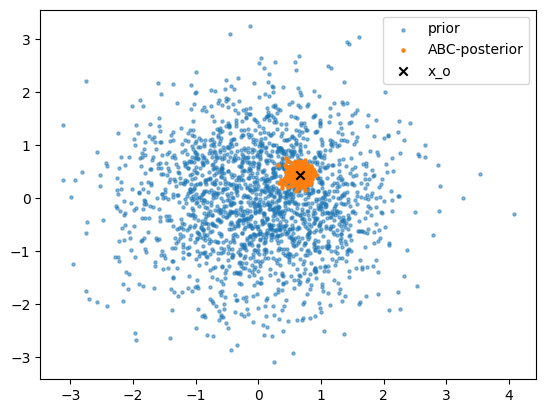

In [80]:
num_prior_samples = 2000
plt.scatter(theta[:num_prior_samples, 0], theta[:num_prior_samples, 1], s=5, alpha=0.5, label="prior")
plt.scatter(posterior_samples[:, 0], posterior_samples[:, 1], s=5, label="ABC-posterior")
plt.scatter(x_o[:, 0],  x_o[:, 1], marker="x", color="k", label="x_o")
plt.legend();

<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">Thank you for the attention!</div>